# 1. Entropie textu

### Každý cyklus
Spočítat $P(i,j)$ - pravděpodobnost výskytu dvojice $i,j$ v textu  
Spočítat $P(j|i)$ - pravděpodobnost výskytu $j$, když se vyskytlo $i$  
Spočítat $H(J|I) = - \sum_{i \in I, j \in J}P(i,j)log_2 P(j|i)$  
Spočítat $PX(P(J|I)) = 2^{H(J|I)}$

### Poškozování textu: znaky - opakovat 10×  
Vytvoř množinu znaků (tečku beru také jako znak znak!)  
10%, 5%, 1%, 0.1%, 0.01%, 0.001%  
Vypočti min, max, střední hodnotu entropie  

### Poškozování textu: slova - opakovat 10×  
Vytvoř množinu slov  
10%, 5%, 1%, 0.1%, 0.01%, 0.001%  
Vypočti min, max, střední hodnotu entropie  

---

## Importy

In [1]:
import numpy as np
import random
from enum import IntEnum
import sys
import math
from tqdm import tqdm, tnrange, tqdm_notebook
import time
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

## Konstanty
Nastavení hlavních parametrů

In [2]:
FILES = ["TEXTEN1.txt", "TEXTCZ1.txt"]
MESSUPPROB = [0,0.00001,0.0001,0.001,0.01,0.05,0.1]
REPEAT = 10
MESSUPTYPE = IntEnum('MESSUPTYPE', 'WORD CHAR')
DEBUG = False
SEED = 84840014
INFO_INDEX = ["Počet slov","Počet znaků","Velikost slovníku","Velikost abecedy","Průměrná délka slova v textu","Průměrná délka slova ve slovníku","Průměrná četnost slov","Maximální četnost slov","Druhá maximální četnost slov","Třetí maximální četnost slov","Nejnižší četnost slov","Počet slov s nejnižší četností","Počet slov délky 1 v textu","Počet slov délky 1 ve slovníku"]


## Načtení dat ze souboru
Načtení dat do listu

In [3]:
def get_data(file):
    with open(file, "r") as f:
        data = np.array([x.replace("\n", "") for x in f.readlines()])
        
    if(DEBUG):
        print("Metoda: get_data")
        print("Soubor: ",file)
        print("Výsledek: ",data)
        print()
        
    return data

## Poškození dat
V následujících metodách jsou poškozována data.
Nejprve se určí množina náhradníků (slov / znaků) a poté jsou data postupně procházena a s nastavenou pravděpodobností dojde ke změně.

In [4]:
def char_mess_up(seed, mess_prob, file):
    original_data = get_data(file)
    original_chars = np.unique(np.concatenate([list(x) for x in original_data]))
    rnd = random.Random()
    rnd.seed(seed)
    
    mess_up_data = original_data.copy()
    for i in range(mess_up_data.size):
        l = list(mess_up_data[i])
        for j in range(len(l)):
            if rnd.random() <= mess_prob:
                l[j] = original_chars[rnd.randrange(original_chars.size)]
        mess_up_data[i] = ''.join(l)
    
    
    if(DEBUG):
        print("Metoda: char_mess_up")
        print("Seed: ",seed)
        print("Pravděpodobnost změny: ",mess_prob)
        print("Soubor: ", file)
        print("Původní data: ", original_data)
        print("Znaky: ", original_chars)
        print("Výsledek: ", mess_up_data)
        print()
        
    
    return mess_up_data

In [5]:
def word_mess_up(seed, mess_prob, file):
    original_data = get_data(file)
    original_words = np.unique(original_data)
    rnd = random.Random()
    rnd.seed(seed)
    
    mess_up_data = original_data.copy()
    for i in range(mess_up_data.size):
        if rnd.random() <= mess_prob:
            mess_up_data[i] = original_words[rnd.randrange(original_words.size)]
            
    if(DEBUG):
        print("Metoda: word_mess_up")
        print("Seed: ",seed)
        print("Pravděpodobnost změny: ",mess_prob)
        print("Soubor: ", file)
        print("Původní data: ", original_data)
        print("Slova: ", original_words)
        print("Výsledek: ", mess_up_data)
        print()
    
    return mess_up_data

## Výpočet entropie
Pro data (list slov) spočítáme entropii.
Nejprve spočítáme četnosti slov $c(i)$ (odečteme 1 od četnosti posledního slova, protože netvoří dvojici), které budeme ukládat do slovníku **i:c(i)**.
Poté spočítáme četnosti dvojic $c(i,j)$, které uložíme také do slovníku **(i,j):c(i,j)**.  
$P(i,j) = \dfrac{c(i,j)}{N-1}$, kde $N$ je velikost dat.  
$P(j|i) = \dfrac{c(i,j)}{\sum_j c(i,j)} = \dfrac{c(i,j)}{c(i)}$  

In [6]:
def entropy(data):
    
    data = np.concatenate((["<s>"],data))
    # Odečíst 1 od četnosti posledního slova, protože to už nemá dvojici a já chci z toho počítat psti
    words, counts = np.unique(data, return_counts=True)
    counts_words = dict(zip(words,counts))
    
    counts_words[data[-1]] -= 1   
    
    counts_pairs = dict()
    for i in range(data.size - 1):
        if (data[i],data[i+1]) in counts_pairs:
            counts_pairs[(data[i],data[i+1])] += 1
        else:
            counts_pairs[(data[i],data[i+1])] = 1
    
    H = 0
    N = data.size
    for pair in counts_pairs:
        H -= counts_pairs[pair]/(N-1)*math.log2(counts_pairs[pair]/counts_words[pair[0]])
    
    PX = math.pow(2,H)
    
    return (H,PX)

## Zobrazení výsledků
Zobrazení výsledků do tabulek

In [7]:
def show_result(results, title):
    for i in range(len(FILES)):
        for j in range(len(MESSUPTYPE)):
            df1 = pd.DataFrame(results[i,j,:,:],index=MESSUPPROB, )
            mean = df1.mean(axis=1)
            df1['Min'] = pd.Series(df1.min(axis=1), index=df1.index)
            df1['Max'] = pd.Series(df1.max(axis=1), index=df1.index)
            df1['Avg'] = pd.Series(mean, index=df1.index)
            display(HTML("<h2>" + FILES[i] + " - " + str(MESSUPTYPE(j+1)).split(".")[1] + "</h2>"))
            display(df1)
            plt.plot(mean.values, label = str(FILES[i] + " - " + str(MESSUPTYPE(j+1)).split(".")[1]))
            plt.plot(mean.values, 'k|')
            
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Mess up')
    plt.ylabel(title)
    plt.title('Graf '+title.lower())
    plt.xticks(list(range(mean.values.size)),[str(x) for x in MESSUPPROB])
    plt.show()
    
    plt.figure()
    for i in range(len(FILES)):
        for j in range(len(MESSUPTYPE)):
            df1 = pd.DataFrame(results[i,j,:,:],index=MESSUPPROB, )
            mean = df1.mean(axis=1)
            plt.plot(mean, label = str(FILES[i] + " - " + str(MESSUPTYPE(j+1)).split(".")[1]))
            plt.plot(mean, 'k|')
            
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Mess up')
    plt.ylabel(title)
    plt.title('Graf '+title.lower())
    plt.show()
    
    plt.figure()
    for i in range(len(FILES)):
        for j in range(len(MESSUPTYPE)):
            df1 = pd.DataFrame(results[i,j,:,:],index=MESSUPPROB, )
            mean = df1.mean(axis=1)
            plt.semilogx(mean, label = str(FILES[i] + " - " + str(MESSUPTYPE(j+1)).split(".")[1]))
            plt.semilogx(mean, 'k|')
            
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Mess up')
    plt.ylabel(title)
    plt.title('Graf '+title.lower())
    plt.show()

# Infromace o textech
Zjištění informací o textu, jako velikost textu, velikost slovníku, abeceda,....
Obsahuje i metodu pro zobrazení v tabulce

In [8]:
def get_info(data):
#     results = np.zeros(shape=(len(INFO_INDEX),len(FILES)), dtype=np.dtype('U16'))
    original_data = data
    results = np.array([original_data.size], dtype=np.dtype('U16'))
    
    results = np.append(results, np.concatenate([list(x) for x in original_data]).size)
    
    
    original_words, counts_words = np.unique(original_data, return_counts=True)
    results = np.append(results, original_words.size)
    
    originalChars = np.unique(np.concatenate([list(x) for x in original_data]))
    results = np.append(results, originalChars.size)
    
    results = np.append(results, "{0:.2f}".format(np.concatenate([list(x) for x in original_data]).size/original_data.size))
    
    results = np.append(results, "{0:.2f}".format(np.concatenate([list(x) for x in original_words]).size/original_words.size))
    
    results = np.append(results, "{0:.2f}".format(np.sum(counts_words)/original_words.size))
    
    c = counts_words.copy()
    w = original_words.copy()
    w = np.delete(w,np.argmax(counts_words))
    c = np.delete(c,np.argmax(counts_words))
    c2 = c.copy()
    w2 = w.copy()
    w2 = np.delete(w,np.argmax(c))
    c2 = np.delete(c,np.argmax(c))
    results = np.append(results, str(np.max(counts_words)) + " [" + original_words[np.argmax(counts_words)] + "]")
    results = np.append(results, str(np.max(c)) + " [" + w[np.argmax(c)] + "]")
    results = np.append(results, str(np.max(c2)) + " [" + w2[np.argmax(c2)] + "]")
    
    results = np.append(results, np.min(counts_words))
    
    results = np.append(results, sum([1 for x in counts_words if x == np.min(counts_words)]))
    
    results = np.append(results, sum([1 for x in original_data if len(x)==1]))
    
    results = np.append(results, sum([1 for x in original_words if len(x)==1]))
        
    return results

In [9]:
def show_info(info):
    for i in range(len(FILES)):
        for j in range(len(MESSUPTYPE)):
            df1 = pd.DataFrame(info[i,j,:,0,:].transpose(), index=INFO_INDEX, columns= MESSUPPROB)
            df1.style.set_properties(**{'text-align': 'right'})
            display(HTML("<h2>" + FILES[i] + " - " + str(MESSUPTYPE(j+1)).split(".")[1] + "</h2>"))
            display(df1)

## Main
### Hlavní cyklus.
Nejprve se nastaví generátor náhodných čísel, který bude generovat semínka pro ostatní generátory (kvůli opakovatelnosti výsledků).
Poté se projdou všechny soubory, všechny typy poškození dat se všemi pravděpodobnostmi.
Nakonec je zavolána funkce pro zobrazení výsledků.

Time:  31 m  50 s



,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422
0.00001,5.287422,5.287421,5.287459,5.287444,5.287457,5.287445,5.287422,5.287402,5.287466,5.287422,5.287402,5.287466,5.287436
0.00010,5.287632,5.287580,5.287668,5.287582,5.287764,5.287730,5.287773,5.287572,5.287868,5.287889,5.287572,5.287889,5.287706
0.00100,5.289558,5.288946,5.288968,5.289306,5.289287,5.289065,5.289621,5.288975,5.289274,5.288640,5.288640,5.289621,5.289164
0.01000,5.307556,5.306819,5.305664,5.305451,5.308209,5.306682,5.307719,5.307791,5.306078,5.307579,5.305451,5.308209,5.306955
0.05000,5.379469,5.383784,5.379752,5.380644,5.381721,5.381419,5.382026,5.379853,5.378787,5.378512,5.378512,5.383784,5.380597
0.10000,5.454999,5.455194,5.460025,5.461863,5.457107,5.453780,5.457496,5.457479,5.453946,5.459724,5.453780,5.461863,5.457161


,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422,5.287422
0.00001,5.287418,5.287372,5.287365,5.287425,5.287391,5.287331,5.287459,5.287376,5.287527,5.287317,5.287317,5.287527,5.287398
0.00010,5.287520,5.286820,5.287389,5.287166,5.287108,5.287280,5.286887,5.287058,5.287078,5.287291,5.286820,5.287520,5.287160
0.00100,5.283008,5.284173,5.282471,5.283999,5.282727,5.284209,5.283638,5.284170,5.282833,5.283369,5.282471,5.284209,5.283460
0.01000,5.253860,5.249285,5.247749,5.249666,5.251462,5.249262,5.250257,5.250705,5.248097,5.249827,5.247749,5.253860,5.250017
0.05000,5.055594,5.055777,5.058352,5.056404,5.050547,5.052118,5.056965,5.058161,5.054394,5.059821,5.050547,5.059821,5.055813
0.10000,4.730929,4.728755,4.729791,4.731405,4.730908,4.727018,4.734554,4.728783,4.726608,4.739884,4.726608,4.739884,4.730863


,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822
0.00001,4.747834,4.747805,4.747795,4.747770,4.747787,4.747802,4.747816,4.747822,4.747822,4.747851,4.747770,4.747851,4.747810
0.00010,4.747704,4.747651,4.747690,4.747697,4.747893,4.747646,4.747734,4.747838,4.747679,4.747719,4.747646,4.747893,4.747725
0.00100,4.746536,4.746806,4.747159,4.747070,4.746955,4.747206,4.747153,4.746776,4.746837,4.746534,4.746534,4.747206,4.746903
0.01000,4.739969,4.737798,4.738953,4.738956,4.737954,4.738655,4.740109,4.738209,4.739869,4.738138,4.737798,4.740109,4.738861
0.05000,4.695905,4.696378,4.699754,4.697576,4.695527,4.701062,4.699564,4.698084,4.695968,4.699761,4.695527,4.701062,4.697958
0.10000,4.635429,4.630678,4.636439,4.639361,4.641940,4.638335,4.632059,4.637591,4.634345,4.640284,4.630678,4.641940,4.636646


,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822,4.747822
0.00001,4.747824,4.747747,4.747719,4.747754,4.747619,4.747602,4.747812,4.747755,4.747642,4.747560,4.747560,4.747824,4.747703
0.00010,4.746541,4.746859,4.746767,4.746841,4.746906,4.746984,4.746922,4.746957,4.747032,4.746926,4.746541,4.747032,4.746874
0.00100,4.738824,4.739129,4.738154,4.738725,4.739303,4.738997,4.738805,4.738208,4.738271,4.739018,4.738154,4.739303,4.738744
0.01000,4.658265,4.660046,4.658367,4.658615,4.658528,4.659160,4.659805,4.658697,4.658641,4.657391,4.657391,4.660046,4.658752
0.05000,4.338760,4.338600,4.336433,4.335633,4.337416,4.334084,4.336756,4.335966,4.337332,4.337688,4.334084,4.338760,4.336867
0.10000,3.999596,4.009205,4.011115,4.007893,4.015659,4.001416,4.007722,4.008888,4.008004,4.010868,3.999596,4.015659,4.008037


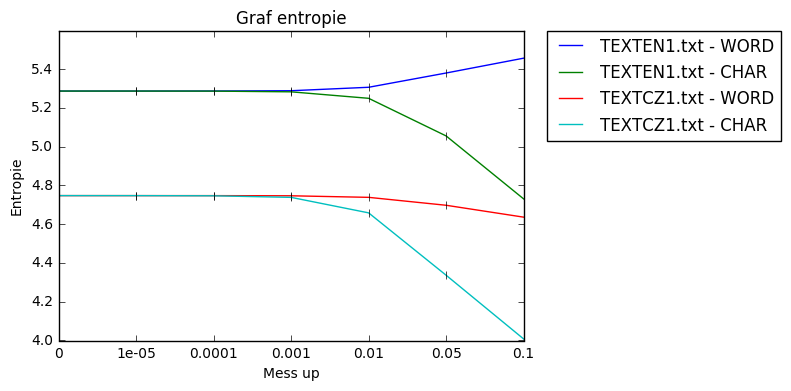

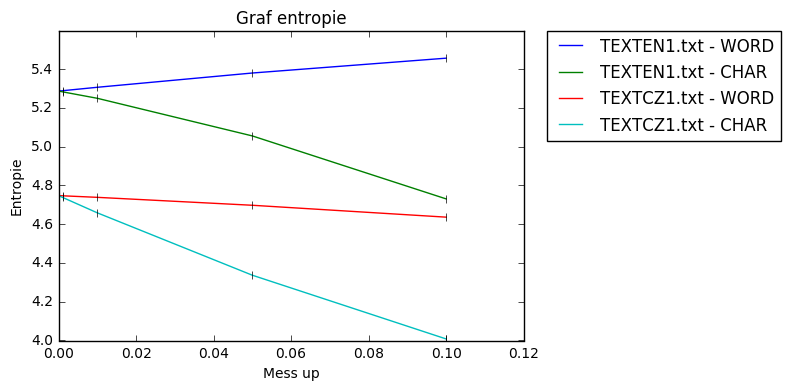

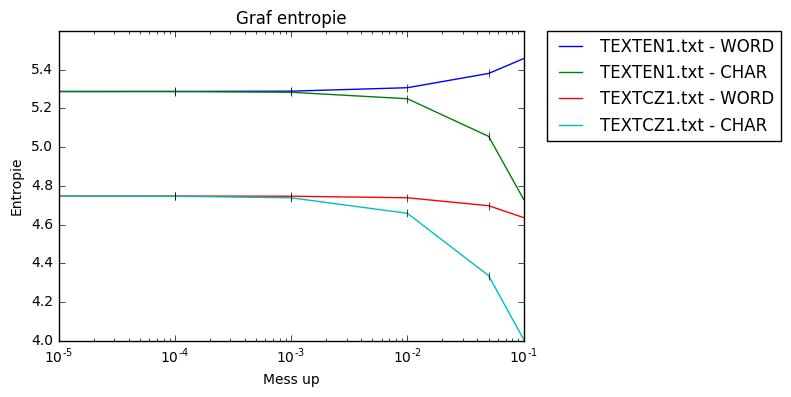

,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632
0.00001,39.054632,39.054612,39.055632,39.055242,39.055596,39.055255,39.054632,39.054084,39.055820,39.054632,39.054084,39.055820,39.055014
0.00010,39.060311,39.058927,39.061295,39.058971,39.063911,39.062967,39.064141,39.058695,39.066723,39.067290,39.058695,39.067290,39.062323
0.00100,39.112510,39.095924,39.096524,39.105662,39.105158,39.099147,39.114215,39.096713,39.104808,39.087629,39.087629,39.114215,39.101829
0.01000,39.603490,39.583280,39.551589,39.545768,39.621419,39.579523,39.607979,39.609939,39.562951,39.604131,39.545768,39.621419,39.587007
0.05000,41.627603,41.752301,41.635784,41.661537,41.692647,41.683924,41.701473,41.638703,41.607946,41.600010,41.600010,41.752301,41.660193
0.10000,43.865032,43.870957,44.018098,44.074220,43.929151,43.827965,43.941020,43.940487,43.833024,44.008930,43.827965,44.074220,43.930888


,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632,39.054632
0.00001,39.054518,39.053293,39.053102,39.054728,39.053810,39.052163,39.055629,39.053394,39.057486,39.051809,39.051809,39.057486,39.053993
0.00010,39.057282,39.038353,39.053738,39.047710,39.046144,39.050795,39.040154,39.044776,39.045333,39.051105,39.038353,39.057282,39.047539
0.00100,38.935345,38.966795,38.920848,38.962091,38.927746,38.967764,38.952350,38.966705,38.930599,38.945069,38.920848,38.967764,38.947531
0.01000,38.156571,38.035771,37.995311,38.045820,38.093212,38.035166,38.061395,38.073222,38.004476,38.050054,37.995311,38.156571,38.055100
0.05000,33.257171,33.261393,33.320822,33.275848,33.141031,33.177156,33.288791,33.316405,33.229535,33.354763,33.141031,33.354763,33.262291
0.10000,26.555325,26.515341,26.534375,26.564074,26.554925,26.483427,26.622121,26.515844,26.475904,26.720674,26.475904,26.720674,26.554201


,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092
0.00001,26.868322,26.867780,26.867593,26.867121,26.867432,26.867719,26.867983,26.868092,26.868092,26.868635,26.867121,26.868635,26.867877
0.00010,26.865904,26.864904,26.865636,26.865762,26.869420,26.864818,26.866458,26.868385,26.865428,26.866170,26.864818,26.869420,26.866289
0.00100,26.844150,26.849176,26.855748,26.854097,26.851959,26.856623,26.855641,26.848626,26.849751,26.844117,26.844117,26.856623,26.850989
0.01000,26.722246,26.682053,26.703435,26.703488,26.684938,26.697912,26.724827,26.689659,26.720394,26.688339,26.682053,26.724827,26.701729
0.05000,25.918405,25.926899,25.987650,25.948442,25.911619,26.011224,25.984218,25.957580,25.919532,25.987765,25.911619,26.011224,25.955333
0.10000,24.854395,24.772682,24.871798,24.922224,24.966817,24.904515,24.796410,24.891675,24.835719,24.938167,24.772682,24.966817,24.875440


,0,1,2,3,4,5,6,7,8,9,Min,Max,Avg
0.00000,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092,26.868092
0.00001,26.868122,26.866700,26.866172,26.866819,26.864305,26.863992,26.867902,26.866838,26.864741,26.863222,26.863222,26.868122,26.865881
0.00010,26.844243,26.850173,26.848443,26.849837,26.851043,26.852492,26.851335,26.851991,26.853383,26.851410,26.844243,26.853383,26.850435
0.00100,26.701039,26.706681,26.688637,26.699214,26.709915,26.704246,26.700694,26.689650,26.690815,26.704638,26.688637,26.709915,26.699553
0.01000,25.250943,25.282133,25.252728,25.257071,25.255536,25.266603,25.277913,25.258507,25.257519,25.235639,25.235639,25.282133,25.259459
0.05000,20.234712,20.232459,20.202092,20.190900,20.215869,20.169231,20.206616,20.195551,20.214682,20.219682,20.169231,20.234712,20.208179
0.10000,15.995515,16.102417,16.123740,16.087779,16.174607,16.015717,16.085864,16.098874,16.089013,16.120987,15.995515,16.174607,16.089451


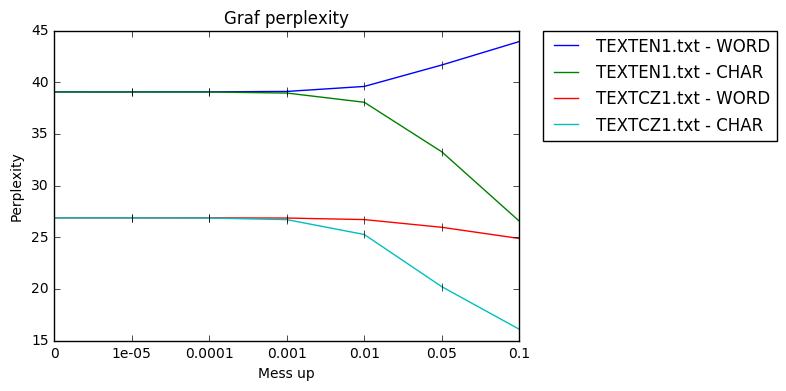

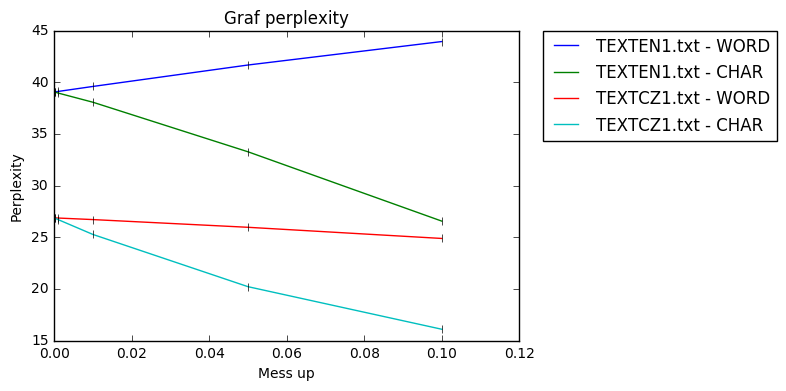

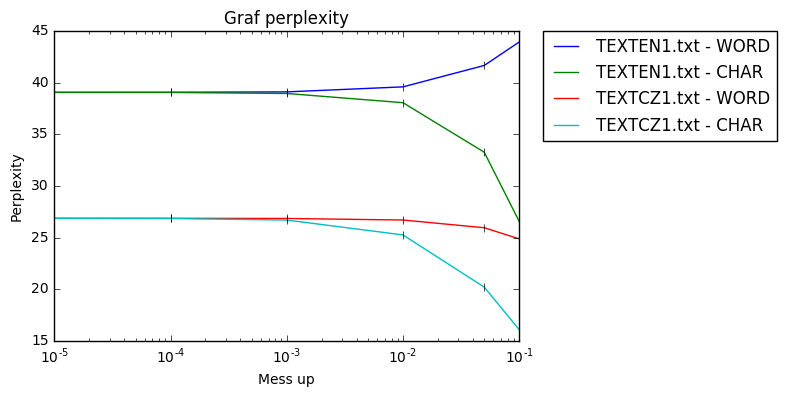

,0.0,1e-05,0.0001,0.001,0.01,0.05,0.1
Počet slov,221098,221098,221098,221098,221098,221098,221098
Počet znaků,972917,972917,972958,973612,979596,1006862,1040612
Velikost slovníku,9607,9607,9606,9601,9587,9557,9568
Velikost abecedy,74,74,74,74,74,74,74
Průměrná délka slova v textu,4.40,4.40,4.40,4.40,4.43,4.55,4.71
Průměrná délka slova ve slovníku,7.43,7.43,7.43,7.43,7.43,7.43,7.43
Průměrná četnost slov,23.01,23.01,23.02,23.03,23.06,23.13,23.11
Maximální četnost slov,"14721 [,]","14721 [,]","14720 [,]","14708 [,]","14591 [,]","13982 [,]","13233 [,]"
Druhá maximální četnost slov,13299 [the],13299 [the],13297 [the],13288 [the],13158 [the],12644 [the],11985 [the]
Třetí maximální četnost slov,9368 [of],9368 [of],9367 [of],9362 [of],9279 [of],8909 [of],8398 [of]


,0.0,1e-05,0.0001,0.001,0.01,0.05,0.1
Počet slov,221098,221098,221098,221098,221098,221098,221098
Počet znaků,972917,972917,972917,972917,972917,972917,972917
Velikost slovníku,9607,9616,9705,10508,17728,42082,64282
Velikost abecedy,74,74,74,74,74,74,74
Průměrná délka slova v textu,4.40,4.40,4.40,4.40,4.40,4.40,4.40
Průměrná délka slova ve slovníku,7.43,7.43,7.42,7.33,7.00,6.81,6.70
Průměrná četnost slov,23.01,22.99,22.78,21.04,12.47,5.25,3.44
Maximální četnost slov,"14721 [,]","14721 [,]","14720 [,]","14706 [,]","14581 [,]","14006 [,]","13326 [,]"
Druhá maximální četnost slov,13299 [the],13299 [the],13292 [the],13262 [the],12907 [the],11450 [the],9695 [the]
Třetí maximální četnost slov,9368 [of],9368 [of],9365 [of],9353 [of],9167 [of],8430 [of],7656 [of]


,0.0,1e-05,0.0001,0.001,0.01,0.05,0.1
Počet slov,222412,222412,222412,222412,222412,222412,222412
Počet znaků,1030631,1030628,1030679,1031250,1037779,1065661,1099956
Velikost slovníku,42826,42825,42821,42802,42580,41786,41227
Velikost abecedy,117,117,117,117,117,117,117
Průměrná délka slova v textu,4.63,4.63,4.63,4.64,4.67,4.79,4.95
Průměrná délka slova ve slovníku,7.72,7.72,7.72,7.72,7.72,7.72,7.71
Průměrná četnost slov,5.19,5.19,5.19,5.20,5.22,5.32,5.39
Maximální četnost slov,"13788 [,]","13788 [,]","13787 [,]","13776 [,]","13635 [,]","13069 [,]","12425 [,]"
Druhá maximální četnost slov,12931 [.],12931 [.],12929 [.],12920 [.],12805 [.],12259 [.],11706 [.]
Třetí maximální četnost slov,4486 [a],4486 [a],4486 [a],4480 [a],4445 [a],4246 [a],4018 [a]


,0.0,1e-05,0.0001,0.001,0.01,0.05,0.1
Počet slov,222412,222412,222412,222412,222412,222412,222412
Počet znaků,1030631,1030631,1030631,1030631,1030631,1030631,1030631
Velikost slovníku,42826,42829,42917,43620,50076,73469,94520
Velikost abecedy,117,117,117,117,117,117,117
Průměrná délka slova v textu,4.63,4.63,4.63,4.63,4.63,4.63,4.63
Průměrná délka slova ve slovníku,7.72,7.72,7.72,7.70,7.60,7.33,7.13
Průměrná četnost slov,5.19,5.19,5.18,5.10,4.44,3.03,2.35
Maximální četnost slov,"13788 [,]","13788 [,]","13784 [,]","13779 [,]","13642 [,]","13124 [,]","12483 [,]"
Druhá maximální četnost slov,12931 [.],12931 [.],12930 [.],12921 [.],12801 [.],12296 [.],11670 [.]
Třetí maximální četnost slov,4486 [a],4486 [a],4486 [a],4481 [a],4445 [a],4283 [a],4093 [a]


In [10]:
start = time.time()
results_H = np.zeros(shape=(len(FILES), len(MESSUPTYPE), len(MESSUPPROB), REPEAT ))
results_P = np.zeros(shape=(len(FILES), len(MESSUPTYPE), len(MESSUPPROB), REPEAT ))
info = np.empty(shape=(len(FILES), len(MESSUPTYPE), len(MESSUPPROB), REPEAT, len(INFO_INDEX) ), dtype="U16")
rnd = random.Random()
rnd.seed(SEED)
for file in tqdm_notebook(FILES, desc='File', leave = False):
    for mess_up_type in tqdm_notebook(MESSUPTYPE, desc='MessUp', leave = False):
        for mess_up_prob in tqdm_notebook(MESSUPPROB, desc='Prob', leave = False):
            for r in tqdm_notebook(range(REPEAT), desc='Repeat', leave = False):
                if(mess_up_type == MESSUPTYPE.WORD):
                    data = word_mess_up(rnd.randrange(sys.maxsize),mess_up_prob, file)
                if(mess_up_type == MESSUPTYPE.CHAR):
                    data = char_mess_up(rnd.randrange(sys.maxsize),mess_up_prob, file)
                
                (h,p) = entropy(data)
                results_H[FILES.index(file), int(mess_up_type)-1, MESSUPPROB.index(mess_up_prob), r] = h
                results_P[FILES.index(file), int(mess_up_type)-1, MESSUPPROB.index(mess_up_prob), r] = p
                info[FILES.index(file), int(mess_up_type)-1, MESSUPPROB.index(mess_up_prob), r, :] = get_info(data)
end = time.time()
print("Time: ",int((end-start)//60) ,"m ",int((end-start)%60) ,"s")
print()

display(HTML("<h1>Entropie</h1>"))
show_result(results_H, "Entropie")
display(HTML("<h1>Perplexity</h1>"))
show_result(results_P, "Perplexity")
display(HTML("<h1>Info o textu</h1>"))
show_info(info)

## Shrnutí výsledků

### Entropie a perplexity původních textů

|             |Anglický text|Český text|
|-------------|------------:|---------:|
|Entropie     |5.287422     |4.747822  |
|Perplexity   |39.054632    |26.868092 |

Vidíme, že anglický text má vyšší entropii než český. To je způsobeno hlavně tím, že anglický text oproti českému má daleko vyšší průměrnou četnost slov (23:5), což je způsobeno tím, že v českém textu se vyskytuje mnohem více slov, které jsou použity pouze jednou.

### Entropie po náhodných změnách znaků
Při náhodné změně znaků dochází k vytváření nových slov. To znamená, že přibývá slov, které se vyskytnou pouze 1. Tedy se entropie snižuje.  
Při změně slova $i$ na $i'$, pokud vznikne nové slovo
$$-\dfrac{c(i,j)}{N-1}log_2 \dfrac{c(i,j)}{c(i)} \geq -\dfrac{c(i,j)-1}{N-1}log_2 \dfrac{c(i,j)-1}{c(i)-1}-0$$
Nerovnost platí díky tomu, že $1 \leq c(i,j) \leq c(i)$  
Při změně slova $i$ na $i'$, pokud nevznikne nové slovo
$$-\dfrac{c(i,j)}{N-1}log_2 \dfrac{c(i,j)}{c(i)}-\dfrac{c(i',j)}{N-1}log_2 \dfrac{c(i',j)}{c(i')} \stackrel{?}{\lesseqgtr} -\dfrac{c(i,j)-1}{N-1}log_2 \dfrac{c(i,j)-1}{c(i)-1}-\dfrac{c(i',j)+1}{N-1}log_2 \dfrac{c(i',j)+1}{c(i')+1}$$
Zde už není odpověď zcela jasná. Mohou nastat všechny případy.

|c(i,j)   |c(i)     |c(i',j)  |c(i')    |Nerovnost|
|--------:|--------:|--------:|--------:|:-------:|
|        2|     1000|        2|     1000|    <    |
|        3|     1000|        2|     1000|    >    |
|        2|       10|        2|     1000|    >    |
|        2|     1000|        2|       10|    <    |

Z tabulky si přibližně dokážeme představit, co se při změnách děje.
Protože český text obsahuje 2× více jednopísmenných slov, a právě u těchto slov nevzniká nové slovo, častěji se bude entropie zvyšovat.
Z grafu také vidíme, že entropie českého textu klesá pomaleji.

### Entropie po náhodných změnách slov
Při této změně nedochází k vzniku nových slov, pouze se upravují jejich četnosti, tomu odpovídá druhý vzorec uvedený výše.
Při náhodné změně slov se v podstatě vyrovnávají četnosti.

Myslím si, že důvodem snížení entropie českého textu je vlastnost logaritmu a vysoký počet slov s četností 1.
Přišli o 11 000 slov s četností 1, buď ztrátou slova (maximálně 1 500 slov) , a nebo zvýšením četnosti (cca 9 500 slov).
U prvního případu entropie roste a u druhého klesá díky vlastnosti logaritmu. 

U anglického textu je to obdobné, ale protože počet slov s malou četností je mnohem méně, mohlo dojít k nárůstu entropie.

## Psací úloha
Co víme:
$$H_1 = H_2 = E$$
$$E = H_1 = -\sum \dfrac{c(i,j)}{N}log_2\dfrac{c(i,j)}{c(i)}$$
$$N*E = -\sum c(i,j)log_2\dfrac{c(i,j)}{c(i)}$$
$$E = H_2 = -\sum \dfrac{c(u,v)}{M}log_2\dfrac{c(u,v)}{c(u)}$$
$$M*E = -\sum c(u,v)log_2\dfrac{c(u,v)}{c(u)}$$
$$E \stackrel{?}{\lesseqgtr} -\sum \dfrac{c(x,y)}{M+N+1}log_2\dfrac{c(x,y)}{c(x)}$$
$$(M+N+1)E \stackrel{?}{\lesseqgtr} -\sum c(x,y)log_2\dfrac{c(x,y)}{c(x)}$$
Nyní rozepíšeme sumu nového textu na entropie $T_1$, $T_2$ a spojovací dvojice:
$$ -\sum c(x,y)log_2\dfrac{c(x,y)}{c(x)} = -\sum c(i,j)log_2\dfrac{c(i,j)}{c(i)} -\sum c(u,v)log_2\dfrac{c(u,v)}{c(u)} - 1log_2 \dfrac{1}{c(i')} = N*E + M*E - log_2 \dfrac{1}{c(i')}$$
kde $i'$ je poslední slovo v textu $T_1$.
Jelikož o hodnotě $-log_2 \dfrac{1}{c(i')}$ víme pouze to, že je větší rovna $0$, nemůžeme porovnat obě strany nerovnice,protože neznáme porovnání k hodnote $E$. Tedy mohou nastat všechny nerovnost (i rovnost).

Entropie spojeného textu, ač jí neumíme určit přesně, bude přibližně E, protože jak jsme si ukázali, závisí pouze na spojovacím členu. 